# APP2 Testing on Mouselight Benchmarking Dataset
Frederick Xu

# Introduction

For the Brainlit team's efforts in determining the best method to trace the mouselight imaging dataset, this Python notebook undertakes the testing and analysis of All-Paths-Pruning 2 (APP2), published by Xiao & Peng et. al. 2013. The algorithm is an improvement upon APP1, published by the same authors in 2011. APP2 makes key modifications to APP1, namely through the use Gray-Weighted Image Distance Transform (GWDT) instead of a Binary Thresholding, Fast-Marching Algorithm instead of Dijkstra's Algorithm for initial reconstruction, and Hierarchical Branch Pruning instead of Linear Branch Pruning for efficiency. GWDT will be used to identify the soma, or "source" of the reconstruction, as the cell body is expected to be a large region of high intensity and can be singled out by GWDT. However, this means that the algorithm is likely to work only in a single-source setting, leading to potential difficulties when attempting to trace multi-source images.

As such, it is hypothesized that APP2 will perform poorly on the Mouselight Benchmarking Dataset. The dataset is a series of cropped tiff images of mouselight neuron data. For this particular experiment, the images labeled "test" will be used. These images are varied in their contents, with some containing multiple parallel axons while others depict more web-like structures. Very few of these images depict cell bodies, adding to the potential of APP2 to fail. The degree of noise in the images also varies, so we may observe APP2's performance under a variety of clean to noisy background conditions. To verify the correctness of the obtained traces, corresponding manual ground truth traces are included in the Mouselight Benchmarking Dataset. Significant Spatial Distance, or SSD, can be computed based on Peng et. al. 2010 and Xiao & Peng et. al. 2013 to gauge the disparity between the the APP2 Trace and the Manually Traced Ground Truth.

The implementation of APP2 being used is included in the 3D Visualization-Assisted Analysis Software Suite (Vaa3D). This application is based in C++ and takes various imaging formats as inputs, one of which is tiff files. The software outputs .swc files that can be analyzed and plotted in napari as label points. To assist in batch testing, an open-source Python wrapper for Vaa3D will also be used.

In [1]:
import numpy as np
import pandas as pd
import napari
import os
import matplotlib.pyplot as plt
from skimage import io
from mouselight_code.src.benchmarking_params import brain_offsets, vol_offsets, scales, type_to_date
from mouselight_code.src import read_swc
from brainlit.utils.swc import df_to_graph, graph_to_paths
from pathlib import Path
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline

C:\Users\frede\anaconda3\envs\brainlit3.7\lib\site-packages\napari\__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.6. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)
C:\Users\frede\anaconda3\envs\brainlit3.7\lib\site-packages\python_jsonschema_objects\__init__.py:53: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  self.schema["$schema"]


## Loading the Vaa3D plugin wrapper

### Installation process:

- Download the Windows64 release version of [Vaa3D v3.447](https://github.com/Vaa3D/release/releases/tag/v3.447)
   - Note that the pyVaa3D wrapper specifically requires v3.447.
- Clone the [pyVaa3D](https://github.com/ajkswamy/pyVaa3d) plugin repository
- Activate the Brainlit `conda` environment, `cd` into the pyVaa3D directory, and `pip install -e .`
- The original instructions can be found [here](https://github.com/ajkswamy/pyVaa3d/blob/master/INSTALL.md).

### Initial Run

- Import the method `from pyVaa3d.vaa3dWrapper import runVaa3dPlugin`

- When importing this function, the terminal will prompt the user to enter the path to the executable `start_vaa3d.sh`. Note that this extension is for Linux. On Windows, the file is `vaa3d_msvc.exe`, and on Mac it is `vaa3d64.app` located inside the `C:Users\...\Vaa3D_V3.447_Windows_MSVC_64bit\` directory. This only needs to be done once, and is cached.

In [2]:
from pyVaa3d.vaa3dWrapper import runVaa3dPlugin

Working Vaa3d executable found at C:\Users\frede\Documents\Y4\Y4_NDD\Vaa3D_V3.447_Windows_MSVC_64bit\Vaa3D_V3.447_Windows_MSVC_64bit\vaa3d_msvc.exe!


## Running APP2

The input to Vaa3D will require a `.tif` file. The current benchmarking dataset supports this filetype. 

- To run APP2 in Vaa3D, use the `runVaa3dPlugin` with the plugin name `Vaa3D_Neuron2` and function name `app2`

- The output of the Vaa3D run will be a `.swc` file in the same directory as the input image file

- Note that there will be 2 `.swc` file outputs, one with a `_ini.swc` extension and one with a coordinate `_xAB_yCD_zEF.swc`. The latter is the proper label output, which will be sparse enough to match the manually labeled traces.

Currently, the following script is set up to only run in `test_X-gfp.tif` files. The script will run APP2 on these 25 test images. This will take roughly 45-60 mins to run.

In [ ]:
# Please put the directory of the mouselight benchmarking dataset here.
directory = r'C:\\Users\\frede\\Documents\\Y4\\Y4_NDD\\benchmarking_datasets\\'
for n in range(1,26):
    fname = 'test_' + str(n) + '-gfp.tif'
    img_name = os.path.join(directory, fname)
    img = io.imread(img_name)

    # NOTE: This will autodump files into the dataset folder, since app2
    # is set up to dump in the source folder.
    print(f"Running APP2 on image {fname}.")
    runVaa3dPlugin(inFile=img_name, pluginName="Vaa3D_Neuron2",
                   funcName="app2")

## Loading the results

As mentioned previously Vaa3D will output 2 `.swc` files, the one of interest has a coordinate `_xAB_yCD_zEF.swc` extension. This is the pruned output that corresponds to the final result, where the `x, y, z` portion of the extension is the location of the soma or root of the reconstruction.

The following script stores the results into a dictionary, where the key is the original input file name without a `.tif` extension. During the loading process, the `x` and `z` dimensions will need to be swapped to correct for a transpose in the labels; this will line up properly with the input image.

In [4]:
# For unpacking the APP2 output .swc files as a list of labels
def app2_swc_unpack(fname):
    """Reads in the results swc file and converts it to a list of (x,y,z)
       coordinates corresponding to labels
    """

    # check input
    file = open(fname, "r")
    skip_header = True
    readable = True
    header_length = -1
    while skip_header:
        line = file.readline().split()
        if line != []:
            if line[0][0] != "#":
                #line = file.readline().split()
                skip_header = False
        else:
            readable = False
            skip_header = False
            
        header_length += 1
    # read coordinates
    if readable:
        df = pd.read_table(
            fname,
            names=["n", "type", "x", "y", "z", "radius", "parent"],
            skiprows=header_length,
            sep="\s+"
        )
    else:
        return None
     
    # NOTE: The read-in order is [z,y,x] since the image is flipped.
    labels = np.array(df[["z","y","x"]])
    return labels

In [5]:
# The results will end up in the same folder as the inputs, 
# so the same directory from before can be used here.
directory = r'C:\\Users\\frede\\Documents\\Y4\\Y4_NDD\\benchmarking_datasets\\'

test_results = {}

for f in os.listdir(directory):
    if f.endswith("app2.swc"):
        test_results[f.split(sep='.')[0]] = app2_swc_unpack(os.path.join(directory, f))

# List of the input data files without .tif extension
fnames = list(test_results.keys())

# Comparing with ground truth labels

## Significant Spatial Distance Metric

One of the metrics used by the APP2 paper is a significant spatial distance metric. The process is as follows:
- Randomly sample nodes from neurons A and B. This step is automatically conducted by APP2 to generate an evenly spaced labelset. It does not need to be done for the ground truth, which largely satisfies this requirement already due to the nature of the manual tracing.
- Calculate the euclidean distance from each sampled node in A to each sampled node in B, and average them. This is known as the the directed divergence, DDIV(A,B)
- The two directed divergences of DDIV(A,B) and DDIV(B,A) are thresholded. Peng et. al. set this threshold to 2, so this is what is used in the implementation here.  
- Lastly, the Significant Spatial Distance (SSD) score is obtained by averaging across these distances.

This is the same function as in https://github.com/neurodata/mouselight_code/blob/tom/swc_evaluate/mouselight_code/src/swc_eval.py, included here for reference.

In [6]:
def ssd(pts1, pts2):
    """Compute significant spatial distance metric between two traces as defined in APP1.
    Args:
        pts1 (np.array): array containing coordinates of points of trace 1. shape: npoints x ndims
        pts2 (np.array): array containing coordinates of points of trace 1. shape: npoints x ndims
    Returns:
        [float]: significant spatial distance as defined by APP1
    """
    _, dists1 = pairwise_distances_argmin_min(pts1, pts2)
    dists1 = dists1[dists1 >= 2]
    _, dists2 = pairwise_distances_argmin_min(pts2, pts1)
    dists2 = dists2[dists2 >= 2]
    dists = np.concatenate([dists1, dists2])
    ssd = np.mean(dists)
    return ssd

APP2 runs rather poorly on many of the testing images, producing traces that are difficult to compare to the input data. As such, one may need to manually look through the APP2-produced reconstructions and determine whether or not they are qualitatively reasonable.

In this notebook, I decided to compute SSD for all APP2 outputs. This gives a better range the SSD metric and allows for comparisons between satisfactory and insatisfactory traces.

In [6]:
# --- Manually Preview the Reconstruction ---
# When manually viewing the reconstructions in napari,
# Jupyter notebook can't display a napari viewer result.
# To see result, please run in a local Python environment.
raw_directory = r'C:\\Users\\frede\\Documents\\Y4\\Y4_NDD\\benchmarking_datasets\\'
fnames = list(test_results.keys())
select_file = fnames[13]
print("File viewed: ", select_file)
img_name = select_file+".tif"

img = io.imread(os.path.join(raw_directory, img_name))
img_labels = test_results[select_file]

with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(img)
    viewer.add_points(img_labels, size=1, opacity=0.5, face_color='red',edge_color='red')

File viewed:  test_21-gfp


## Loading the ground truth labels

Original ground truth label loading code was provided in a notebook by Tommy. This was further modified to create label-lists instead of branches of trees. SSD does a one-against-all distance comparison of an entire labelset so it needs to be loaded as such.

In [8]:
# Target files for inputs. Here, I am using every file that APP2 was ran on.
target_files = fnames 

# Directory of the input data
raw_directory = r'C:\\Users\\frede\\Documents\\Y4\\Y4_NDD\\benchmarking_datasets\\'
im_dir = Path(raw_directory)
gfp_files = list(im_dir.glob("**/*-gfp.tif"))
# Path of the manual ground truth data
swc_base_path = im_dir / "Manual-GT"

gt_labels = {}

# (Loading code courtesy of Tommy.)
# for every image
for im_num, im_path in enumerate(gfp_files):
    
    f = im_path.parts[-1][:-8].split("_")
    image = f[0]

    date = type_to_date[image]
    num = int(f[1])
    img_name = image + "_" + str(num) + "-gfp"
    
    # Skip the file if it's not of interest
    if img_name not in target_files:
        continue
    
    # More file reading
    scale = scales[date]
    brain_offset = brain_offsets[date]

    vol_offset = vol_offsets[date][num]
    im_offset = np.add(brain_offset, vol_offset)
    
    # Parse the proper directory
    lower = int(np.floor((num - 1) / 5) * 5 + 1)
    upper = int(np.floor((num - 1) / 5) * 5 + 5)
    dir1 = date + "_" + image + "_" + str(lower) + "-" + str(upper)
    dir2 = date + "_" + image + "_" + str(num)
    swc_path = swc_base_path / dir1 / dir2
    
    # Read swcs
    swc_files = list(swc_path.glob("**/*.swc"))
    #im = io.imread(im_path, plugin="tifffile")
    #print(f"Image shape: {im.shape}")
    path_total = []
    for swc_num, swc in enumerate(swc_files):
        if "cube" in swc.parts[-1]:
            # skip the bounding box swc
            continue

        df, swc_offset, _, _, _ = read_swc.read_swc(swc)

        #compute the offset of the swc relative to the image
        offset_diff = np.subtract(swc_offset, im_offset)
        G = df_to_graph(df)

        paths = graph_to_paths(G)
        # for every path in that swc
        for path_num, p in enumerate(paths):
            #convert from spatial coordinates to voxel coordinates
            pvox = (p + offset_diff) / (scale) * 1000
            
            # Swap the columns to orient properly
            pvox[:, [2, 0]] = pvox[:, [0, 2]] 
            path_total.extend(pvox)
    gt_labels[img_name] = path_total

print("Ground truth loading done.")

Ground truth loading done.


### Compute SSD metric

The SSD metric is set to None if the APP2 reconstruction produced an empty trace. Otherwise, the SSD is calculated using the aforementioned formula.

In [9]:
SSD = {}
for img_name in list(gt_labels.keys()):
    if test_results[img_name] is None:
        SSD[img_name] = None
        continue
    SSD[img_name] = ssd(test_results[img_name], gt_labels[img_name])

print("SSD computation done.")

SSD computation done.


### View the comparison

The following code opens a napari session, displaying the original image file along with ground truth in Green and the APP2 labels in Red. The soma of the APP2 labels is included as a yellow dot.

In [10]:
image_of_interest = "test_8-gfp"#target_files[6]
img = io.imread(os.path.join(raw_directory, image_of_interest + ".tif"))
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(img)
    viewer.add_points(gt_labels[image_of_interest], size=1, opacity=0.5, face_color='green',edge_color='green')
    viewer.add_points(test_results[image_of_interest], size=1, opacity=0.5, face_color='red',edge_color='red')   
    viewer.add_points(test_results[image_of_interest][0], size=5, opacity=0.5, face_color='yellow',edge_color='yellow')
print(f"SSD of {image_of_interest}: {SSD[image_of_interest]}")

SSD of test_8-gfp: 14.600591677443768


Note: There are a few problems with some of the images. test_9-gfp, test_10-gfp, and test_24-gfp have some ground truth misalignment issues, so these will be omitted.

The following cell plots a bar graph depicting the SSD metrics for each image. The y-axis is in microns, as the resolution of the images is 1 micron.

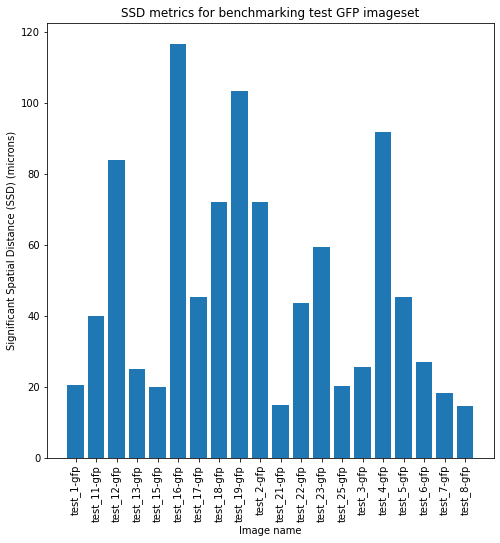

In [11]:
keys = []
metrics = []
items_to_drop = ["test_9-gfp", "test_10-gfp", "test_24-gfp"]
for i in list(SSD.keys()):
    if i in items_to_drop:
        continue
    if SSD[i] != None:
        keys.append(i)
        metrics.append(SSD[i])

plt.figure(figsize=(8,8))
plt.bar(range(len(metrics)),metrics)
plt.xticks(np.arange(len(keys)), keys, rotation='vertical')
plt.title("SSD metrics for benchmarking test GFP imageset")
plt.xlabel("Image name")
plt.ylabel("Significant Spatial Distance (SSD) (microns)")

SSD_data = pd.DataFrame(SSD.values(),index=SSD.keys())
SSD_data.style

# Analysis of the results

Overall, we can observe that APP2 was largely unsuccessful in replicating the manually traced labels. The lowest SSD is 15.05 microns. When taking a closer look at the results, we can observe many problems that the algorithm ran into.

Firstly, for the 3 of the 4 highest SSD-scoring images (16, 19, 12), there is a very notable issue of separated axons, where there may be multiple axons running through an image slice while being disconnected. APP2 does poorly as it makes an assumption about having a single-source, or soma, to originate from. As such, the algorithm is only successful in tracing one of these axons that run through the image slice, while the others go unnoticed. From the positions of the soma (yellow marker), we can see that only one point of origination is selected, and the algorithm traces until it is unable to branch out any further due to encountering background. This creates a very high SSD score, as the distances drawn from the APP2-trace to the ground-truth-trace span a large gap.

For the final image, test_4-gfp, this is a case of a very noisy image being difficult for APP2 to handle. We can see that the algorithm is unsure of what is noise and what is neuron, and subsequently traces everything. The high SSD is a result of there being only 1 true axon that runs through the imageslice, again resulting in very long distance draws between the APP2-trace and ground-truth-trace.

Text(0.5, 1.0, 'test_12-gfp, SSD: 83.76570696706045')

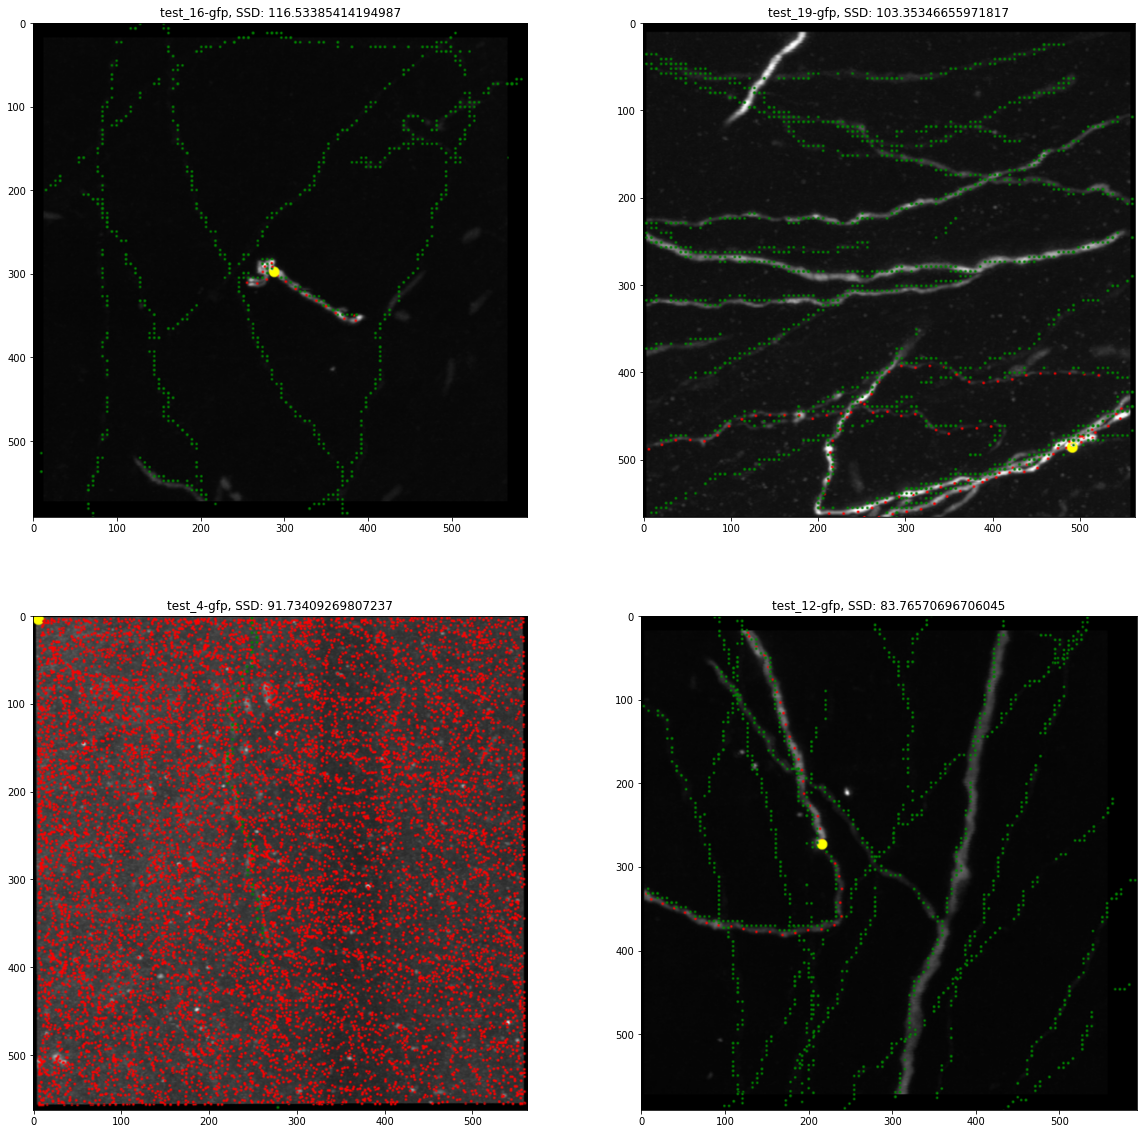

In [12]:
imagedir = ""
results16 = io.imread(imagedir+"test_16-gfp_app2compare.png")
results19 = io.imread(imagedir+"test_19-gfp_app2compare.png")
results4 = io.imread(imagedir+"test_4-gfp_app2compare.png")
results12 = io.imread(imagedir+"test_12-gfp_app2compare.png")


fig, axs = plt.subplots(2, 2,figsize=(20,20)) 
axs[0,0].imshow(results16)
axs[0,0].set_title(f"test_16-gfp, SSD: {SSD['test_16-gfp']}");
axs[0,1].imshow(results19)
axs[0,1].set_title(f"test_19-gfp, SSD: {SSD['test_19-gfp']}");
axs[1,0].imshow(results4)
axs[1,0].set_title(f"test_4-gfp, SSD: {SSD['test_4-gfp']}");
axs[1,1].imshow(results12)
axs[1,1].set_title(f"test_12-gfp, SSD: {SSD['test_12-gfp']}")

Of the previous images, test_4-gfp was the most extreme example of APP2's sensitivity to noise in the testing images. Similar examples of this sensitivity vary in SSD scores. test_1-gfp and test_25-gfp showed similar results of noise sensitivity, despite being in the lower range of SSD scores at ~20. test_2-gfp and test_23-gfp have moderately high SSD scores of 72.1 and 59.4 respectively, but also display similar tendencies to trace noise. It appears that SSD does not necessarily provide information of whether or not a trace is satisfactory, as it depends on the ground truth trace complexity. We can observe that test_1-gfp and test_25-gfp have more complex ground truth traces, spanning a larger area than those of test_2-gfp and test_23-gfp. This results in a lower SSD score, as each point in an APP2-trace of 1 and 25 is relatively closer to a ground truth compared to that of 2 and 23.

Text(0.5, 1.0, 'test_23-gfp, SSD: 59.41435955358509')

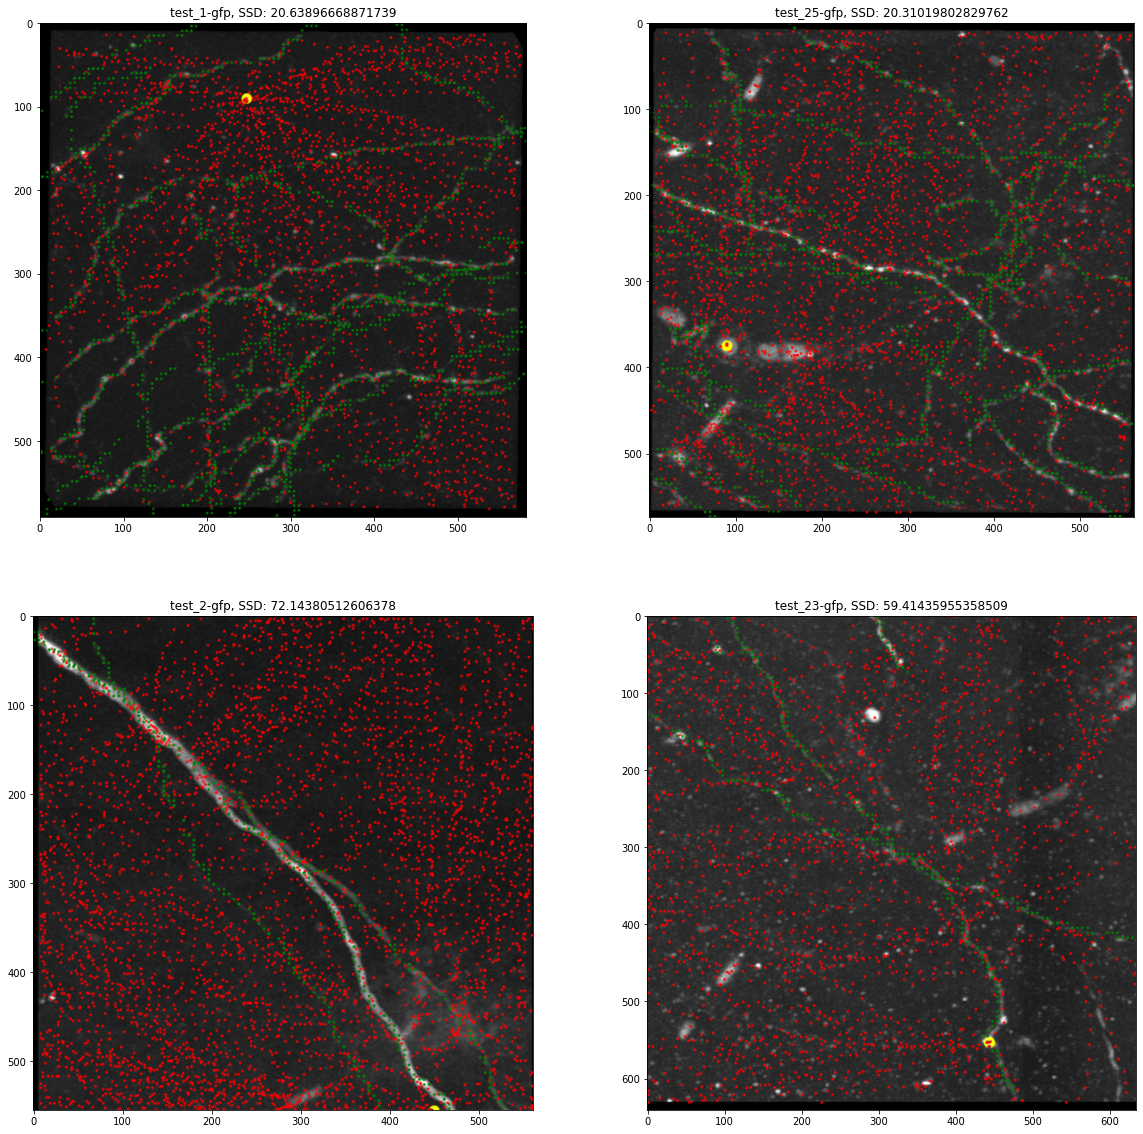

In [13]:
results1 = io.imread(imagedir+"test_1-gfp_app2compare.png")
results25 = io.imread(imagedir+"test_25-gfp_app2compare.png")
results2 = io.imread(imagedir+"test_2-gfp_app2compare.png")
results23 = io.imread(imagedir+"test_23-gfp_app2compare.png")


fig2, axs2 = plt.subplots(2, 2,figsize=(20,20)) 
axs2[0,0].imshow(results1)
axs2[0,0].set_title(f"test_1-gfp, SSD: {SSD['test_1-gfp']}");
axs2[0,1].imshow(results25)
axs2[0,1].set_title(f"test_25-gfp, SSD: {SSD['test_25-gfp']}");
axs2[1,0].imshow(results2)
axs2[1,0].set_title(f"test_2-gfp, SSD: {SSD['test_2-gfp']}");
axs2[1,1].imshow(results23)
axs2[1,1].set_title(f"test_23-gfp, SSD: {SSD['test_23-gfp']}")

Lastly, APP2 performed qualitatively well in 2 of the tested images. APP2 on test_21-gfp managed to trace most of the ground truth, however it deviated and began tracing background, despite the regions of low intensity. The best-performing image was test_15-gfp, where APP2 managed to capture most of the ground truth trace, with the exception of a few smaller trace segments that run along the side of the image. It is very apparent that the neurons spanning these two images can be described by a single source, as such APP2 is relatively successful in tracing these images. With regards to SSD scores, test-21_gfp had a low SSD score of 15.1, while test-15_gfp had an SSD score of 19.9. Despite test-15_gfp being a more successful trace, its SSD score is higher than that of test-21_gfp. It appears that SSD is a relatively inaccurate metric to use to decide trace quality.

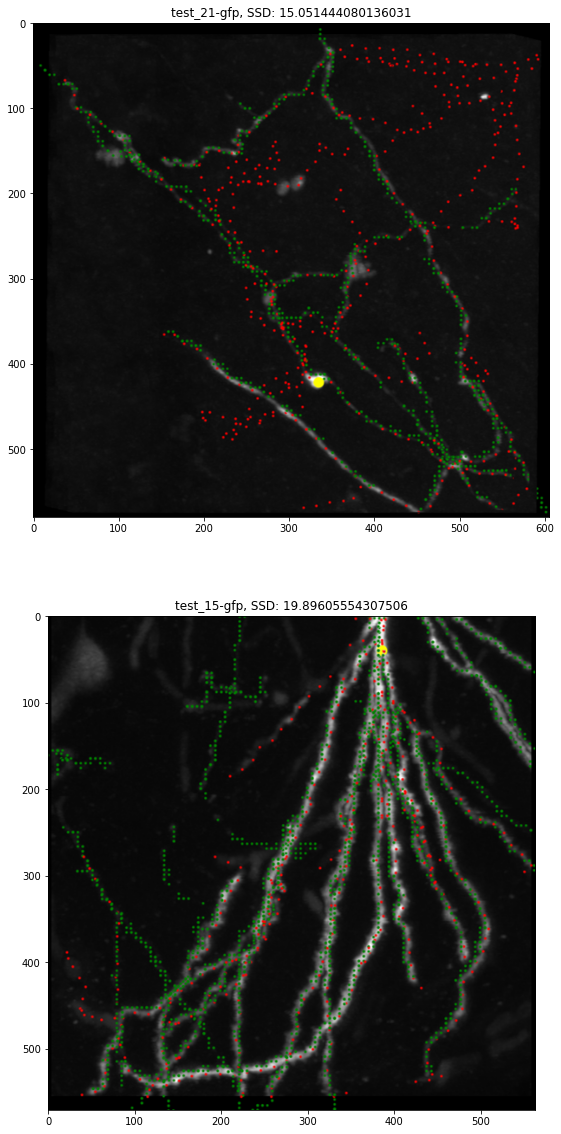

In [14]:
results21 = io.imread(imagedir+"test_21-gfp_app2compare.png")
results15 = io.imread(imagedir+"test_15-gfp_app2compare.png")

fig3, axs3 = plt.subplots(2, 1,figsize=(10,20)) 
axs3[0].imshow(results21)
axs3[0].set_title(f"test_21-gfp, SSD: {SSD['test_21-gfp']}");
axs3[1].imshow(results15)
axs3[1].set_title(f"test_15-gfp, SSD: {SSD['test_15-gfp']}");

To further inspect the fact that SSD may not be a particularly good metric to indicate trace accuracy, we can inspect test_8-gfp which had the lowest SSD score of 14.6. We can see that, although the neuron has been successfully traced, there is still large detection of noise, creating erroneous labels on the fringes of the neuron. Overall, this performance is not adequate as it once again shows the algorithm's sensitivity to noise in these images.

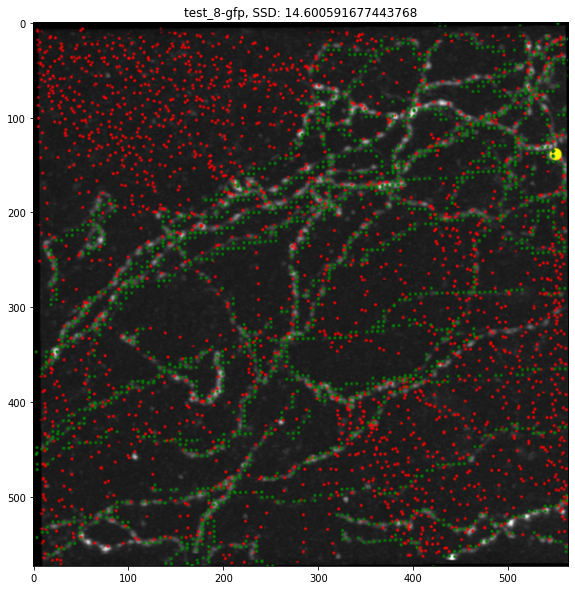

In [15]:
results8 = io.imread(imagedir+"test_8-gfp_app2compare.png")

fig4, axs4 = plt.subplots(1, 1,figsize=(10,10)) 
axs4.imshow(results8)
axs4.set_title(f"test_8-gfp, SSD: {SSD['test_8-gfp']}");

# Conclusions

Based on the implementation characteristics of APP2, it was hypothesized that the algorithm would perform poorly for images that could contain "multiple sources", as the algorithm relies on a single-source assumption. The results depicted here demonstrate the algorithm's inability to trace across large gaps in the image, where multiple axons may be running through an image slice in a disconnected fashion. Additionally, the algorithm's sensitivity to noise was unknown. A quite common outcome observed was the algorithm bleeding outwards into noisy portions of the background, creating numerous erroneous traces. As such, this algorithm is poorly fit for the tracing task that we wish to undertake. If we were to further test this algorithm, we may wish to consider modifications that could potentially allow for multi-source traces, or manually specify a soma on a larger imageslice that contains a whole neuron. It must also be said that these testing images very rarely mimic a potential situation with a whole neuron present, so perhaps testing on images more suited for the algorithm's implementation assumptions will yield better results.

# References

## Papers

1. Xiao, H., & Peng, H. (2013). APP2: automatic tracing of 3D neuron morphology based on hierarchical pruning of a gray-weighted image distance-tree. Bioinformatics (Oxford, England), 29(11), 1448–1454. https://doi.org/10.1093/bioinformatics/btt170

2. Peng H, Long F, Myers G. Automatic 3D neuron tracing using all-path pruning. Bioinformatics. 2011 Jul 1;27(13):i239-47. doi: 10.1093/bioinformatics/btr237. PMID: 21685076; PMCID: PMC3117353.

3. Peng, H., Ruan, Z., Long, F., Simpson, J. H., & Myers, E. W. (2010). V3D enables real-time 3D visualization and quantitative analysis of large-scale biological image data sets. Nature biotechnology, 28(4), 348–353. https://doi.org/10.1038/nbt.1612

## Software and Packages

1. Peng, H. et. al. (2019) 3D Visualization-Assisted Analysis Software Suite. Allen Institute for Brain Science.

2. Kumaraswamy, A. (2018) PyVaa3D Python Package. https://github.com/ajkswamy/pyVaa3d

3. Certain code snippets courtesy of Thomas Athey.